<a href="https://colab.research.google.com/github/mschrader15/homework/blob/main/spring-2022/ece-693/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction to homework**
This homework explores conditional GAN that produces images conditioned on class labels. This homework is based on the example by Sayak Paul available at https://keras.io/examples/generative/conditional_gan/

"Generative Adversarial Networks (GANs) let us generate novel image data, video data,
or audio data from a random input. Typically, the random input is sampled
from a normal distribution, before going through a series of transformations that turn
it into something plausible (image, video, audio, etc.).

However, a simple [DCGAN](https://arxiv.org/abs/1511.06434) doesn't let us control
the appearance (e.g. class) of the samples we're generating. For instance,
with a GAN that generates MNIST handwritten digits, a simple DCGAN wouldn't let us
choose the class of digits we're generating.
To be able to control what we generate, we need to _condition_ the GAN output
on a semantic input, such as the class of an image."

In this homework, you'll train a **Conditional GAN** that can generate food images of a given class.

The original MNIST example is based on these references:

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)
* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

For a description of GANs, you can refer to the "Generative adversarial networks"
section of
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).

This homework requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [ ]:
%pip install -q git+https://github.com/tensorflow/docs
%pip install imageio
%pip install scikit-image
%pip install joblib

## Imports

In [5]:
import os
import shutil
import glob
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
from skimage.transform import resize
from joblib import Parallel, delayed


## Constants and hyperparameters

In [12]:
batch_size = 64

# RGB
num_channels = 3

# cats and dogs
num_classes = 2

image_size = 64
latent_dim = 128

IMG_SIZE = (image_size, image_size)


## Loading the dataset and preprocessing it




### **Assignment dataset**

Note that below is the original code for loading the MNIST dataset. In this homework you could use **one** of the following:
1. CIFAR10 dataset. This dataset is included with Keras, See https://keras.io/api/datasets/cifar10/
2. Cats and Dogs dataset. This dataset is available from Kaggle. The textbook has examples of working with this dataset in the image classification section. https://www.kaggle.com/competitions/dogs-vs-cats/data
3. Food101 dataset, also available from Kaggle. https://www.kaggle.com/datasets/kmader/food41

Regardless of the dataset you choose, a couple of important considerations:
- Unlike the MNIST example, these are color images and the GAN should be able to produce color images.
- Keep the image resolution and number of classes manageable, otherwise the network will take too long or will not properly train.

**Modify the code below to load the dataset of your choice**

Please either use wget links or include the data in the same directory as your code.
Note that I'll not be able to access files mounted on your Google drive, so the data should be local to the runtime instance!!! You could use wget or gdown to download required files.

In [9]:
# install the kaggle library
%pip install kaggle
# download the data
!mkdir ./data
!kaggle competitions download -c dogs-vs-cats
!mv dogs-vs-cats.zip ./data

Note: you may need to restart the kernel to use updated packages.
mkdir: cannot create directory ‘./data’: File exists
100%|████████████████████████████████████████▉| 810M/812M [00:08<00:00, 102MB/s]
100%|█████████████████████████████████████████| 812M/812M [00:08<00:00, 102MB/s]


### Unzip and Unpack the Data

In [10]:
!unzip "./data/dogs-vs-cats.zip" -d "./data/"
!rm -r -f "./data/sampleSubmission.csv" "./data/dogs-vs-cats.zip"


Archive:  ./data/dogs-vs-cats.zip
  inflating: ./data/sampleSubmission.csv  
  inflating: ./data/test1.zip        
  inflating: ./data/train.zip        


In [11]:

!unzip -qq -o "./data/test1.zip" -d "./data/"
!unzip -qq -o "./data/train.zip" -d "./data/"
!rm -r -f "./data/**.zip"

### Store the File Paths

In [1]:
ROOT = os.path.abspath("")
TEST_DATA = os.path.join(ROOT, "data", "test1")
TRAIN_DATA = os.path.join(ROOT, "data", "train")


### Split the Data into Test, Train and Validate

In [6]:
def make_subset(data_dir, subset_name, start_index, end_index) -> str:
    for category in ("cat", "dog"):
        new_dir = os.path.join(data_dir, subset_name, category)
        try:
            os.makedirs(new_dir)
            fnames = [
                (f"{category}.{i}.jpg", f"{i}-{category}.jpg")
                for i in range(start_index, end_index)
            ]
            for fname in fnames:
                shutil.copyfile(
                    src=os.path.join(data_dir, fname[0]),
                    dst=os.path.join(new_dir, fname[1]),
                )
        except FileExistsError:
            break
    return os.path.join(data_dir, subset_name)


In [7]:
_, _, files = next(os.walk(TRAIN_DATA))
print(num_images := len(files))


25000


#### Loading the Datasets

In [6]:
DATA_PERCENTAGE = 100 / 100


In [59]:
file_list = glob.glob(os.path.join(TRAIN_DATA, "dog.*.jpg"))
print(len(file_list))


12500


In [58]:
file_list = np.random.choice(
    file_list, int(num_images * DATA_PERCENTAGE), replace=False
)


NameError: name 'DATA_PERCENTAGE' is not defined

In [82]:
def process_img(fname: str) -> np.array:
    return resize(np.array(Image.open(fname)), IMG_SIZE)


img_data = Parallel(n_jobs=60)(delayed(process_img)(fname) for fname in file_list)
img_data = np.array(img_data)


In [72]:
img_data.shape


(12500, 64, 64, 3)

In [83]:
labels = np.array([1 * ("dog" in fname) for fname in file_list])
labels


array([1, 1, 1, ..., 1, 1, 1])

In [96]:
preprocessing_layer = keras.Sequential(
        [
            tf.keras.layers.RandomTranslation(0.1, 0.1),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.3),
            tf.keras.layers.RandomZoom(0.5),
        ]
    )


In [111]:
# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
# img_data = np.reshape(img_data, (-1, *IMG_SIZE, 3))
# labels = keras.utils.to_categorical(labels, 1)

# Create tf.data.Dataset.
# dataset = tf.data.Dataset.from_tensor_slices((img_data, labels))
dataset = tf.data.Dataset.from_tensor_slices((img_data))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
dataset = dataset.map(lambda x: (preprocessing_layer(x)))
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

print(f"Shape of training images: {img_data.shape}")
print(f"Shape of training labels: {labels.shape}")


Shape of training images: (12500, 64, 64, 3)
Shape of training labels: (12500,)


### Plotting Image to Ensure Everything OK

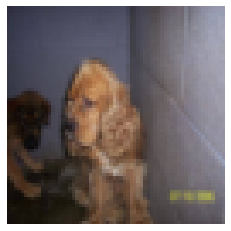

In [123]:
import matplotlib.pyplot as plt

# plotting the data augmentation and the color distortion
# plt.figure(figsize=(10, 10))
plt.figure()
for images in dataset.take(1):
    # augmented_images = data_augementation()(images)
    # ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy())
    plt.axis("off")


## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [124]:
generator_in_channels = latent_dim  # num_classes
discriminator_in_channels = num_channels  # + 1 # num_classes
print(generator_in_channels, discriminator_in_channels)


128 3


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

Note that you need to adjust these models for work with color images.

In [166]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        # keras.layers.InputLayer((*IMG_SIZE, discriminator_in_channels)),
        # tf.keras.layers.RandomTranslation(0.05, 0.05),
        # tf.keras.layers.RandomFlip("horizontal"),
        # tf.keras.layers.RandomRotation(0.05),
        # tf.keras.layers.RandomZoom(0.05),
        # layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        # layers.BatchNormalization(),
        # layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        # layers.BatchNormalization(),
        # layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        # layers.BatchNormalization(),
        # layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(256 * 2, kernel_size=4, strides=2, padding="same"),
        # # layers.BatchNormalization(),
        # # layers.LeakyReLU(alpha=0.2),
        # # layers.Conv2D(1, kernel_size=4, strides=1, padding="valid"),
        # layers.Flatten(),
        # layers.Dropout(0.2),
        # layers.Dense(1, activation="sigmoid"),
        keras.Input(shape=(*IMG_SIZE, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(generator_in_channels,)),
        # layers.Reshape()
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # layers.Conv2DTranspose(
        #     IMG_SIZE[0] * 2, kernel_size=4, strides=2, padding="same"
        # ),
        # layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2DTranspose(
            IMG_SIZE[0] * 4, kernel_size=4, strides=2, padding="same"
        ),
        # layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2DTranspose(
            IMG_SIZE[0] * 8, kernel_size=4, strides=2, padding="same"
        ),
        # layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.LeakyReLU(alpha=0.2),
        # ayers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=8, padding="same", activation="sigmoid"),        
        # layers.Conv2DTranspose(
        #     # input_shape=(IMG_SIZE[0], 32, 32),
        #     filters=3,
        #     kernel_size=5,
        #     strides=2,
        #     padding="same",
        # ),
        # layers.Activation("tanh"),
    ],
    name="generator",
)


# generator = keras.Sequential(
#     [
#         keras.Input(shape=(generator_in_channels,)),
#         layers.Dense(8 * 8 * 128),
#         layers.Reshape((8, 8, 128)),
#         layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
#     ],
#     name="generator",
# )


In [159]:
generator2 = keras.Sequential(
    [
        keras.Input(shape=(generator_in_channels,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

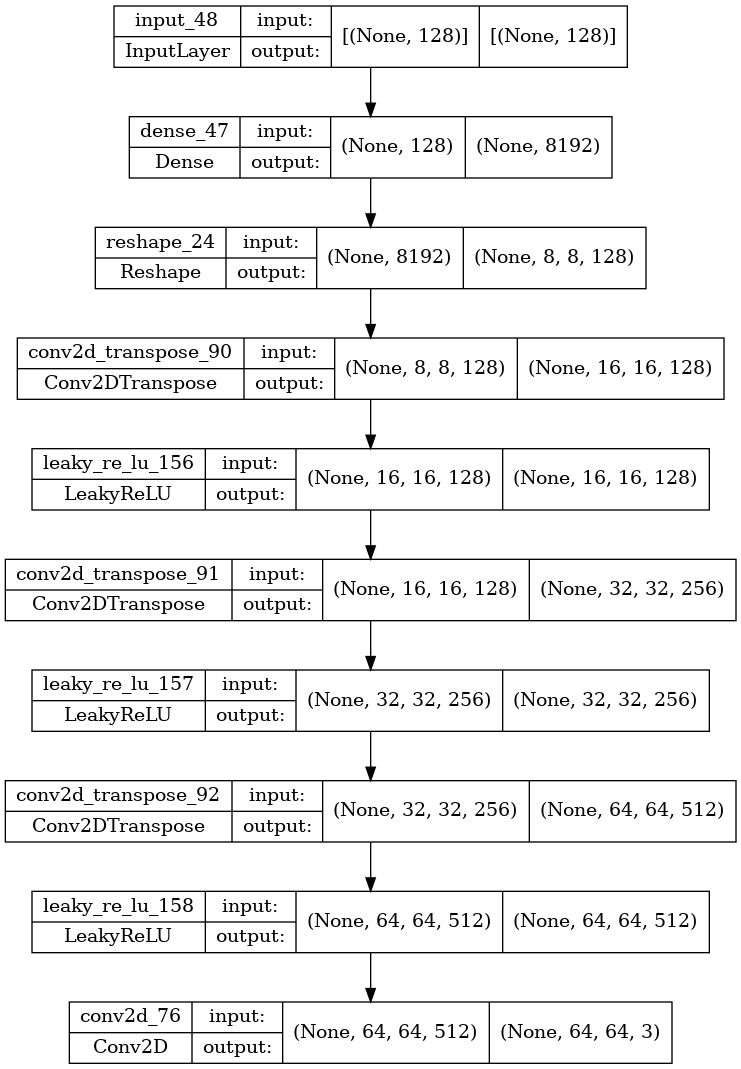

In [167]:
tf.keras.utils.plot_model(generator2, show_shapes=True)

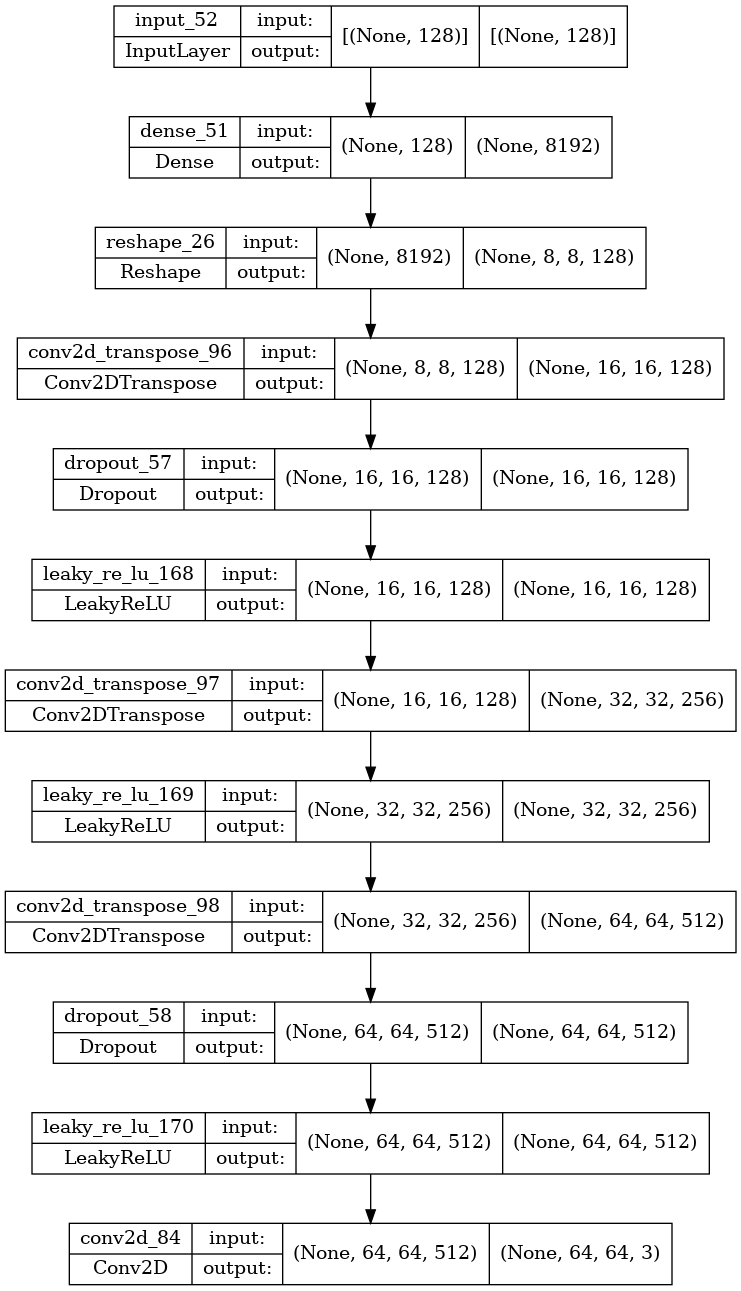

In [168]:
tf.keras.utils.plot_model(generator, show_shapes=True)


## Creating a `ConditionalGAN` model

In [1]:
# class ConditionalGAN(keras.Model):
#     def __init__(self, discriminator, generator, latent_dim):
#         super(ConditionalGAN, self).__init__()
#         self.discriminator = discriminator
#         self.generator = generator
#         self.latent_dim = latent_dim
#         self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
#         self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

#     @property
#     def metrics(self):
#         return [self.gen_loss_tracker, self.disc_loss_tracker]

#     def compile(self, d_optimizer, g_optimizer, loss_fn):
#         super(ConditionalGAN, self).compile()
#         self.d_optimizer = d_optimizer
#         self.g_optimizer = g_optimizer
#         self.loss_fn = loss_fn

#     def train_step(self, data):
#         # Unpack the data.
#         real_images, one_hot_labels = data

#         # Add dummy dimensions to the labels so that they can be concatenated with
#         # the images. This is for the discriminator.
#         image_one_hot_labels = one_hot_labels[:, :, None, None]
#         image_one_hot_labels = tf.repeat(
#             image_one_hot_labels, repeats=[image_size * image_size]
#         )
#         image_one_hot_labels = tf.reshape(
#             image_one_hot_labels, (-1, image_size, image_size, num_classes)
#         )

#         # Sample random points in the latent space and concatenate the labels.
#         # This is for the generator.
#         batch_size = tf.shape(real_images)[0]
#         random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
#         random_vector_labels = tf.concat(
#             [random_latent_vectors, one_hot_labels], axis=1
#         )

#         # Decode the noise (guided by labels) to fake images.
#         generated_images = self.generator(random_vector_labels)

#         # Combine them with real images. Note that we are concatenating the labels
#         # with these images here.
#         fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
#         real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
#         combined_images = tf.concat(
#             [fake_image_and_labels, real_image_and_labels], axis=0
#         )

#         # Assemble labels discriminating real from fake images.
#         labels = tf.concat(
#             [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
#         )

#         # Train the discriminator.
#         with tf.GradientTape() as tape:
#             predictions = self.discriminator(combined_images)
#             d_loss = self.loss_fn(labels, predictions)
#         grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
#         self.d_optimizer.apply_gradients(
#             zip(grads, self.discriminator.trainable_weights)
#         )

#         # Sample random points in the latent space.
#         random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
#         random_vector_labels = tf.concat(
#             [random_latent_vectors, one_hot_labels], axis=1
#         )

#         # Assemble labels that say "all real images".
#         misleading_labels = tf.zeros((batch_size, 1))

#         # Train the generator (note that we should *not* update the weights
#         # of the discriminator)!
#         with tf.GradientTape() as tape:
#             fake_images = self.generator(random_vector_labels)
#             fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
#             predictions = self.discriminator(fake_image_and_labels)
#             g_loss = self.loss_fn(misleading_labels, predictions)
#         grads = tape.gradient(g_loss, self.generator.trainable_weights)
#         self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

#         # Monitor loss.
#         self.gen_loss_tracker.update_state(g_loss)
#         self.disc_loss_tracker.update_state(d_loss)
#         return {
#             "g_loss": self.gen_loss_tracker.result(),
#             "d_loss": self.disc_loss_tracker.result(),
#         }


NameError: name 'keras' is not defined

In [169]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Training the Conditional GAN

**Do not forget to save the model after training and include the model with the submission**

In [163]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        # generated_images *= 255
        generated_images = generated_images.numpy()

        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(os.path.join(ROOT, "data", f"generated_img_{epoch:03d}_{i}.png"))


In [170]:
checkpoint_filepath = os.path.join(ROOT, "model_checkpoint")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "gan.keras",
    save_weights_only=True,
    monitor="g_loss",
    mode="min",
    save_best_only=True,
)

cond_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.5
    ),
    g_optimizer=keras.optimizers.Adam(
        learning_rate=0.00002,
        beta_1=0.5
    ),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cond_gan.fit(
    dataset,
    epochs=500,
    callbacks=[GANMonitor(num_img=1, latent_dim=generator_in_channels)],
)


Epoch 1/500
196/196 [==============================] - 56s 274ms/step - d_loss: 0.3255 - g_loss: 2.2455
Epoch 2/500
196/196 [==============================] - 54s 277ms/step - d_loss: 0.2188 - g_loss: 3.6319
Epoch 3/500
196/196 [==============================] - 55s 278ms/step - d_loss: 0.2002 - g_loss: 3.5387
Epoch 4/500
196/196 [==============================] - 55s 279ms/step - d_loss: 0.2192 - g_loss: 3.2416
Epoch 5/500
196/196 [==============================] - 55s 279ms/step - d_loss: 0.1933 - g_loss: 3.2676
Epoch 6/500
196/196 [==============================] - 55s 279ms/step - d_loss: 0.1241 - g_loss: 3.8193
Epoch 7/500
196/196 [==============================] - 55s 279ms/step - d_loss: 0.2237 - g_loss: 2.9923
Epoch 8/500
196/196 [==============================] - 55s 279ms/step - d_loss: 0.1985 - g_loss: 3.0583
Epoch 9/500
196/196 [==============================] - 55s 279ms/step - d_loss: 0.2437 - g_loss: 3.1006
Epoch 10/500
196/196 [==============================] - 55s 278m

## Interpolating between classes with the trained generator

**Load the model from the file, generate images**

Note that the class choice may be set the same for start_class and end_class. In this case generate 1 image of the target class.

In [ ]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    return trained_gen.predict(noise_and_labels)


start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
end_class = 7  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)


NameError: ignored

Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label indentities being present in some proportion.


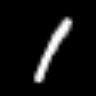

In [ ]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")


We can further improve the performance of this model with recipes like
[WGAN-GP](https://keras.io/examples/generative/wgan_gp).
Conditional generation is also widely used in many modern image generation architectures like
[VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
etc.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conditional-gan) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conditional-GAN).

# **Grading**

*   (10 pts) Report quality / submission requirement followed (see class policy)
*   (90 pts) Correctness of the implementation. The basis is ability of the network to generate coherent shapes that may remotely resemble instances of the target class (as opposed to random noise).
*   (10 pts bonus) Explore how **one** of the following affects the realism of image generattion: 1) number of classes; 2) size of the latent dimension; 3) image resolution; 4) increasing the depth / layer type (e.g. implementing residual connections) of the discriminator



# **Submission**
Using Blackboard, submit the .ipynb file, the dataset files, saved models and the report in a compressed folder as defined by the class policy.

Note that I will not have access to your Google drive. All files must be local or downloadable by wget/gdown. 